In [144]:
### Script to train LASSO model for prediction of outcome class on Munich Data

#############################################
# Prerequisites - Load Libraries

In [145]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/stark_stemi_R_Env_4_1//lib/R/library"


In [146]:
source('MS4_Plot_Config.r')

###############################################
# Preqrequisites Configurations & Parameters

In [147]:

result_path_rep =  "../results/current/Reproduction"

result_path =  "../results/current"

In [148]:
name = 'V_AZIMUTH_INTEGRATED'   # name of dataset to load

# Load Data 

## Prepared combined data

In [149]:
### Load MU normalized and integrated data based on azimuth annotations

In [150]:
path = paste0(result_path, '/G-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(file.info(path)$mtime)

[1] "2024-01-11 15:27:29 CET"


In [151]:
head(data_long,2)

,X,sample_id,variable,value,type
,<int>,<chr>,<chr>,<dbl>,<chr>
1,1,k1,CK,-2.397022,clinical_data
2,2,k10,CK,NA,clinical_data


In [152]:
unique(data_long$type)

[1] "clinical_data" "cytokine"      "neutrophil"    "proteomics"   
[5] "single_cell"

In [153]:
### Adjust to MU azimuth annotations to map to cell-type names from Groningen data
data_long$feature = data_long$variable

data_long$feature = str_replace( data_long$feature, 'CD14.Mono','cMono' )
data_long$feature = str_replace( data_long$feature, 'CD16.Mono','ncMono' )
data_long$feature = str_replace( data_long$feature, 'CD4.CTL','CD4_CTL' )
data_long$feature = str_replace( data_long$feature, 'CD4.Naive','CD4_Naive')
data_long$feature = str_replace( data_long$feature, 'CD4.TCM','CD4_TCM' )
data_long$feature = str_replace( data_long$feature, 'CD4.TEM','CD4_TEM' )
data_long$feature = str_replace( data_long$feature, 'CD8.Naive','CD8_Naive' )
data_long$feature = str_replace( data_long$feature, 'CD8.TEM','CD8_TEM' )
data_long$feature = str_replace( data_long$feature, 'NK__','Nkdim__' )

In [154]:
data_long$variable = data_long$feature

In [155]:
data_long$view = str_replace(data_long$variable, '__.*', '')

## Selected Features

In [156]:
# Load subset of features selected based on highest ranking Factor3/ Factor4 features

In [157]:
features_gb = read.csv(paste0(result_path_rep, '/G10_Joint_Features_GB', '.csv'))

In [158]:
nrow(features_gb)

[1] 135

In [159]:
head(features_gb,2)

,type,variable_name,Factor4,Factor3azimuth
,<chr>,<chr>,<dbl>,<dbl>
1,CD4_TCM,ATP5F1E,0.7390619,-0.6764393
2,CD4_TCM,ATP5ME,0.8346074,-0.7521005


In [160]:
unique(features_gb$type)

[1] "CD4_TCM"       "cDC2"          "clinical_data" "cMono"        
[5] "cytokine"      "ncMono"        "Nkdim"         "proteomics"

In [161]:
## Remove non-sc dimensions (as in Groningen data only sc data available)

In [162]:
features_gb = features_gb[!features_gb$type %in% c('clinical_data', 'cytokine', 'proteomics'),]

In [163]:
sort(unique(features_gb$type))

[1] "CD4_TCM" "cDC2"    "cMono"   "ncMono"  "Nkdim"

In [164]:
### compare to types in data input (to make sure they match)
sort(unique(data_long$view[data_long$type == 'single_cell']))

[1] "B.cell"    "CD4_CTL"   "CD4_Naive" "CD4_TCM"   "CD4_TEM"   "CD8_Naive"
 [7] "CD8_TEM"   "cDC2"      "cMono"     "gdT"       "ncMono"    "Nkdim"    
[13] "Treg"

In [165]:
nrow(features_gb)

[1] 109

In [166]:
## Get only NK cell features for pre-selected feature set 

In [167]:
features_gb_NK = features_gb[features_gb$type == 'Nkdim',]

In [168]:
features_gb_NK = features_gb_NK[features_gb_NK$variable_name %in% c('GZMB', 'TXNIP', 'CD53'),] # only selected nk cell features

## Sample Data

In [169]:
# Load meta-data about samples

In [170]:
sample_data = read.csv(paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv'))

In [171]:
# Log-transform clinical values

In [172]:
sample_data$CK_raw = sample_data$CK

In [173]:
sample_data$CK = log2(sample_data$CK+1)

In [174]:
sample_data$Troponin = log2(sample_data$Troponin+1)

In [175]:
sample_data$CK_MB = log2(as.numeric(sample_data$CK_MB)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [176]:
sample_data$CRP =  log2(as.numeric(sample_data$CRP)+1)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [177]:
## Recode sample-ids of duplicates

In [178]:
sample_data$sample_id[(sample_data$sample_id == 'm13.2')  & (sample_data$library %in%  c('L6'))] = 'm13.22'

In [179]:
sample_data$sample_id[(sample_data$sample_id == 'm6.4')  & (sample_data$library %in%  c('L10'))] = 'm6.42'

In [180]:
sample_data$sample_id[(sample_data$sample_id == 'm6.1')  & (sample_data$library %in%  c('L3'))] = 'm6.12'

In [181]:
## Adjust sample data columns/ generate some new mappings

In [182]:
sample_data$class = sample_data$group

In [183]:
sample_data$measurement2 = sample_data$measurement

In [184]:
sample_data$measurement2[sample_data$class %in% c('no_ccs', 'ccs')] = paste0(sample_data$measurement[sample_data$class %in% c('no_ccs', 'ccs')] , '_', sample_data$class[sample_data$class %in% c('no_ccs', 'ccs')])

In [185]:
sample_data$measurement_class =  paste0(sample_data$measurement , '_', sample_data$classification)

In [186]:
unique(sample_data$measurement2)

[1] "TP0_no_ccs" "TP0_ccs"    "TP1"        "TP2"        "TP3"       
[6] "TP4"

In [187]:
unique(sample_data$measurement_class)

[1] "TP0_vollstaendiger_ausschluss" "TP0_ccs"                      
 [3] "TP0_koronarsklerose"           "TP1_acs_subacute"             
 [5] "TP2_acs_subacute"              "TP3_acs_subacute"             
 [7] "TP4_acs_subacute"              "TP1_acs_w_infection"          
 [9] "TP2_acs_w_infection"           "TP3_acs_w_infection"          
[11] "TP4_acs_w_infection"           "TP1_acs_w_o_infection"        
[13] "TP2_acs_w_o_infection"         "TP3_acs_w_o_infection"        
[15] "TP4_acs_w_o_infection"

In [188]:
# Summarize good and intermediate outcome    
sample_data$delta_ef_value_class_summarized = sample_data$delta_ef_value_class
sample_data$delta_ef_value_class_summarized[sample_data$delta_ef_value_class %in% c('intermediate')] = 'good'

In [189]:
unique(sample_data$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

In [190]:
## Concatenate outcome with class

In [191]:
sample_data$tp_outcome = paste0(sample_data$measurement, '_', sample_data$delta_ef_value_class_summarized)

In [192]:
unique(sample_data$tp_outcome)

[1] "TP0_NA"   "TP1_NA"   "TP2_NA"   "TP3_NA"   "TP4_NA"   "TP1_bad" 
 [7] "TP2_bad"  "TP3_bad"  "TP4_bad"  "TP1_good" "TP2_good" "TP3_good"
[13] "TP4_good"

# Train Prediction Model

## Prepare Data

In [193]:
# Adjust the format of some columns

In [194]:
data_long$sample_id = as.character(data_long$sample_id)

In [195]:
data_long$type = str_replace(data_long$variable, '__.*', '')
data_long$type = str_replace(data_long$type, '\\.', '')

In [196]:
data_long$variable_name = str_replace(data_long$variable, '.*__', '')

### Prepare train input for all top features of Factor3/4

In [197]:
## Filter on pre-selected features

In [198]:
train_input = merge(data_long, features_gb)  # combine normalized expression data with features

In [199]:
head(train_input,2)

,type,variable_name,X,sample_id,variable,value,feature,view,Factor4,Factor3azimuth
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,CD4_TCM,ATP5F1E,729181,m26.1,CD4_TCM__ATP5F1E,-0.560703,CD4_TCM__ATP5F1E,CD4_TCM,0.7390619,-0.6764393
2,CD4_TCM,ATP5F1E,729174,m24.1,CD4_TCM__ATP5F1E,NA,CD4_TCM__ATP5F1E,CD4_TCM,0.7390619,-0.6764393


In [200]:
### Transform to wide format

In [201]:
train_input = train_input %>% dcast(sample_id ~ variable, value.var = 'value')

In [202]:
nrow(train_input)

[1] 128

In [203]:
head(train_input,2)

,sample_id,CD4_TCM__ATP5F1E,CD4_TCM__ATP5ME,CD4_TCM__ATP5MPL,CD4_TCM__C6orf48,CD4_TCM__COX6A1,CD4_TCM__COX7C,CD4_TCM__EIF1,CD4_TCM__EVI2B,CD4_TCM__HLA.F,⋯,Nkdim__GZMB,Nkdim__HLA.A,Nkdim__HLA.F,Nkdim__IQGAP2,Nkdim__LITAF,Nkdim__POLR2L,Nkdim__PRF1,Nkdim__RSRP1,Nkdim__TMA7,Nkdim__TXNIP
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,k1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,k10,0.2211187,0.02089009,0.512454,0.4887764,0.08365173,0.05224518,-0.4653698,-0.1573107,1.731664,⋯,1.191816,0.7279133,1.191816,0.6614351,1.110772,-0.01044447,0.5977601,-0.01044447,-0.9674216,0.9027348


In [204]:
### remove samples with only NA values

In [205]:
train_input = train_input[!is.na(rowSums(train_input[,2:ncol(train_input)])),]

In [206]:
### Add sample meta-data to train-input

In [207]:
train_input = merge(train_input, sample_data[,c('sample_id', 'measurement', 'delta_ef_value_class_summarized', 'delta_ef_value', 'classification')], by.x = 'sample_id', by.y = 'sample_id')

In [208]:
nrow(train_input)

[1] 119

In [209]:
### Filter on only TP1 observations

In [210]:
train_input = train_input[train_input$measurement == 'TP1',]

In [211]:
nrow(train_input)

[1] 22

In [212]:
head(train_input,2)

,sample_id,CD4_TCM__ATP5F1E,CD4_TCM__ATP5ME,CD4_TCM__ATP5MPL,CD4_TCM__C6orf48,CD4_TCM__COX6A1,CD4_TCM__COX7C,CD4_TCM__EIF1,CD4_TCM__EVI2B,CD4_TCM__HLA.F,⋯,Nkdim__LITAF,Nkdim__POLR2L,Nkdim__PRF1,Nkdim__RSRP1,Nkdim__TMA7,Nkdim__TXNIP,measurement,delta_ef_value_class_summarized,delta_ef_value,classification
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
34,m1.1,0.8268302,0.3076702,1.439531,0.08365173,1.0364334,0.7009514,0.2858409,-0.7835004,-0.01044447,⋯,0.93458929,-0.1678940,1.258162,-0.1573107,0.9027348,1.439531,TP1,NA,NA,acs_subacute
40,m12.1,-1.2133396,-1.0364334,-1.191816,1.13033917,-0.7009514,-1.3056645,0.5607030,1.8339146,0.52440051,⋯,0.06270678,-0.7279133,1.001331,0.5005801,-1.8339146,1.281552,TP1,NA,NA,acs_w_o_infection


In [213]:
## Generate y column that should be predicted based on outcome

In [214]:
train_input$y = NA
train_input$y[train_input$delta_ef_value_class_summarized == 'good'] = 0 
train_input$y[train_input$delta_ef_value_class_summarized == 'bad'] = 1 

In [215]:
## Overview amount of samples per y-class
train_input %>% group_by(y) %>% count()

y,n
<dbl>,<int>
0,13
1,4
NA,5


### Prepare train input for NK cell feature model

In [216]:
### Filter normalized expression data only on selected NK cell features

In [217]:
train_input_NK = merge(data_long, features_gb_NK)

In [218]:
head(train_input_NK,2)

,type,variable_name,X,sample_id,variable,value,feature,view,Factor4,Factor3azimuth
,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,Nkdim,CD53,1070209,k1,Nkdim__CD53,NA,Nkdim__CD53,Nkdim,-0.6532577,0.5319476
2,Nkdim,CD53,1070221,k20,Nkdim__CD53,-0.4537622,Nkdim__CD53,Nkdim,-0.6532577,0.5319476


In [219]:
### Transform to wide format

In [220]:
train_input_NK = train_input_NK %>% dcast(sample_id ~ variable, value.var = 'value')

In [221]:
### Remove samples with only NA values in sc data

In [222]:
train_input_NK = train_input_NK[!is.na(rowSums(train_input_NK[,2:ncol(train_input_NK)])),]

In [223]:
nrow(train_input_NK)

[1] 119

In [224]:
### Add sample meta-data to train input

In [225]:
train_input_NK = merge(train_input_NK, sample_data[,c('sample_id', 'measurement', 'delta_ef_value_class_summarized', 'delta_ef_value', 'classification')], by.x = 'sample_id', by.y = 'sample_id')

In [226]:
nrow(train_input_NK)

[1] 119

In [227]:
### Filter on ony TP1 observations

In [228]:
train_input_NK= train_input_NK[train_input_NK$measurement == 'TP1',]

In [229]:
nrow(train_input_NK)

[1] 22

In [230]:
### Generate prediction column y based on outcome

In [231]:
train_input_NK$y = NA
train_input_NK$y[train_input_NK$delta_ef_value_class_summarized == 'good'] = 0 
train_input_NK$y[train_input_NK$delta_ef_value_class_summarized == 'bad'] = 1 

In [232]:
unique(train_input_NK$delta_ef_value_class_summarized)

[1] NA     "bad"  "good"

## Train Model

### Model for top Factor3/Factor4 Features

In [233]:
## Remove NA outcomes

In [234]:
train_input = train_input[!is.na(train_input$y),]

In [235]:
## Define y and predictor variables x ; remove unnnecessary columns from x

In [236]:
y = train_input$y
x = train_input
x$sample_id = NULL
x$measurement = NULL
x$delta_ef_value_class_summarized = NULL
x$delta_ef_value = NULL
x$y = NULL
x$classification = NULL
x = data.matrix(x)

In [237]:
nrow(train_input)

[1] 17

In [238]:
### Explanatory features matrix

In [239]:
head(x,2)

,CD4_TCM__ATP5F1E,CD4_TCM__ATP5ME,CD4_TCM__ATP5MPL,CD4_TCM__C6orf48,CD4_TCM__COX6A1,CD4_TCM__COX7C,CD4_TCM__EIF1,CD4_TCM__EVI2B,CD4_TCM__HLA.F,CD4_TCM__HNRNPDL,⋯,Nkdim__GZMB,Nkdim__HLA.A,Nkdim__HLA.F,Nkdim__IQGAP2,Nkdim__LITAF,Nkdim__POLR2L,Nkdim__PRF1,Nkdim__RSRP1,Nkdim__TMA7,Nkdim__TXNIP
42,-1.731664,-1.330562,0.1997621,1.130339,0.1891184,-1.501086,1.330562,0.01044447,1.568920,-2.3939798,⋯,0.9345893,1.501086,0.871771,1.110772,1.5010859,-1.439531,0.6744898,-0.2318344,-1.235440,0.5485223
46,-1.439531,-1.959964,-1.0013313,1.191816,0.1467450,-1.780464,2.393980,0.84162123,1.833915,-0.5485223,⋯,0.9345893,1.191816,2.393980,1.501086,0.9345893,-1.191816,2.1280452,-1.2354403,-1.534121,0.8565988


In [240]:
ncol(x)

[1] 109

In [241]:
dim(x)

[1]  17 109

In [242]:
## Perform k-fold cross-validation to find optimal lambda value
set.seed(49)
cv_model = cv.glmnet(x, y, alpha = 1, family = "binomial",   nfolds = 8, nlambda = 100) 

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”
Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dang

In [243]:
### Resulting model 

In [244]:
cv_model


Call:  cv.glmnet(x = x, y = y, nfolds = 8, alpha = 1, family = "binomial",      nlambda = 100) 

Measure: Binomial Deviance 

     Lambda Index Measure     SE Nonzero
min 0.03313    51  0.4261 0.1497       6
1se 0.09658    28  0.5750 0.1440       2

In [245]:
min(cv_model$cvm)

[1] 0.4260917

In [246]:
### Choose best lambda as minimum

In [247]:
best_lambda = cv_model$lambda.min
best_lambda

[1] 0.0331308

In [248]:
### Plot the output of the cross-validation runs for review figure

In [249]:
figure_name = 'SUPP12_CV_GLMNET_Result'

png 
  2

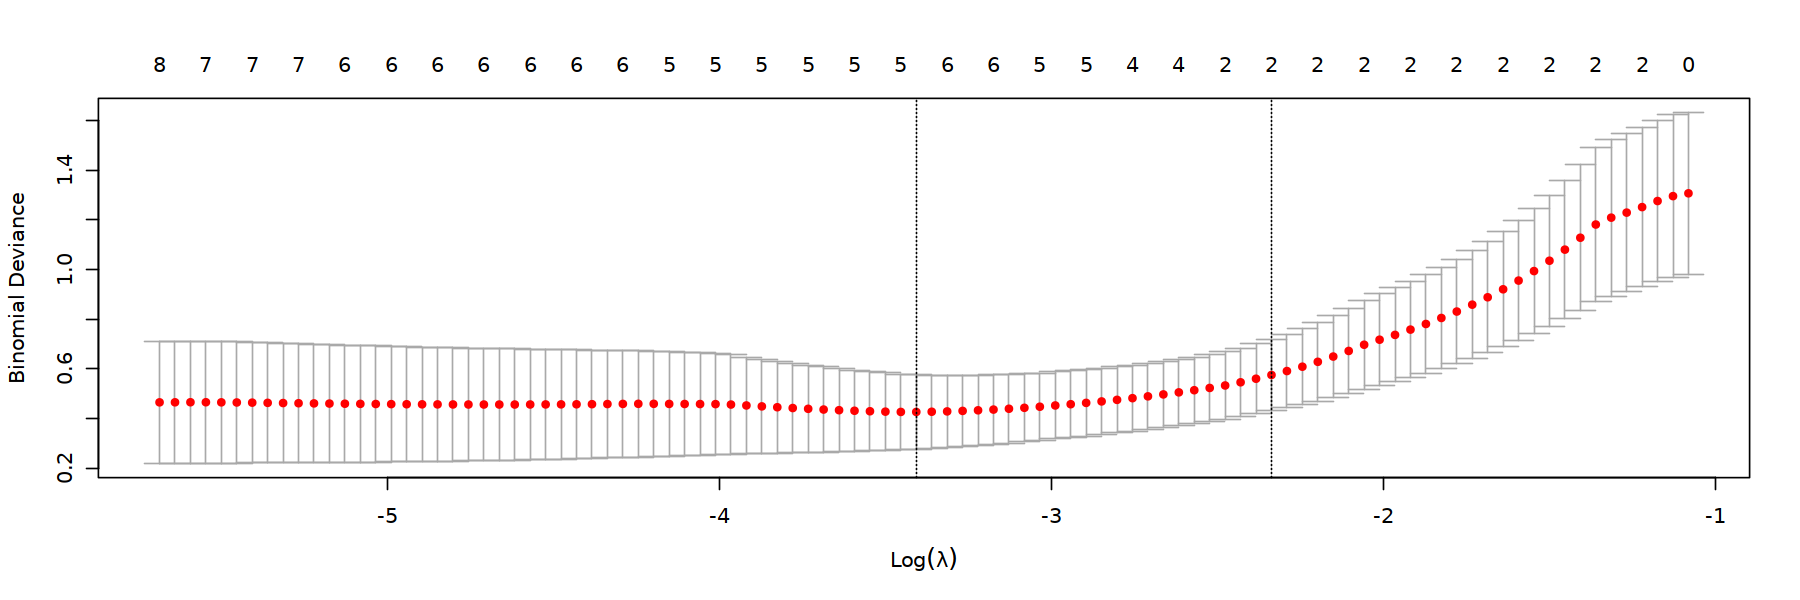

In [250]:
#produce plot of test MSE by lambda value
options(repr.plot.width=15, repr.plot.height=5)
pdf(paste0('figures/Supplementary_Figures/', figure_name,  '.pdf'), width =  8, height =5)
plot(cv_model) 
dev.off()
plot(cv_model)

In [251]:
# Define best model based on the best_lambda

In [252]:
best_model = glmnet(x, y, alpha = 1, lambda = best_lambda , family = 'binomial')

Warning message in lognet(xd, is.sparse, ix, jx, y, weights, offset, alpha, nobs, :
“one multinomial or binomial class has fewer than 8  observations; dangerous ground”


In [253]:
# Get the coefficients of the model

In [254]:
model_coef = coef(best_model)

In [255]:
# Determine the model coefficients

In [256]:
model_coef = as.data.frame(as.matrix(model_coef))
model_coef$variable = rownames(model_coef)

In [257]:
#model_coef[abs(model_coef$s0) > 0,]

In [258]:
### Save the model

In [259]:
paste0(result_path_rep, '/GX3_Model', '.Rdata')

[1] "../results/current/Reproduction/GX3_Model.Rdata"

In [260]:
save(best_model, file = paste0(result_path_rep, '/GX3_Model', '.Rdata'))

In [261]:
write.csv(data.frame(features = colnames(x)), paste0(result_path_rep, '/GX3_input_features_lasso.csv'))

### Model for selected NK cell features

In [262]:
### remove NA observations from outcome

In [263]:
train_input_NK = train_input_NK[!is.na(train_input_NK$y),]

In [264]:
## Determine y and x for model

In [265]:
y_NK = train_input_NK$y
x_NK = train_input_NK
x_NK$sample_id = NULL
x_NK$measurement = NULL
x_NK$delta_ef_value = NULL
x_NK$delta_ef_value_class_summarized = NULL
x_NK$y = NULL
x_NK$classification = NULL
x_NK = data.matrix(x_NK)

In [266]:
head(x_NK,2)

,Nkdim__CD53,Nkdim__GZMB,Nkdim__TXNIP
42,0.3186394,0.9345893,0.5485223
46,2.3939798,0.9345893,0.8565988


In [267]:
#head(y,5)

In [268]:
### Train the logistic regressin model on the features

In [269]:
model_NK = glm(data = data.frame(y_NK, x_NK),formula =  'y_NK~.', family = binomial(link = "logit"))

In [270]:
summary(model_NK)


Call:
glm(formula = "y_NK~.", family = binomial(link = "logit"), data = data.frame(y_NK, 
    x_NK))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2774  -0.7164  -0.4097  -0.1625   2.0163  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept)   -2.7682     1.9229  -1.440    0.150
Nkdim__CD53    0.6956     0.9314   0.747    0.455
Nkdim__GZMB    0.2096     1.4423   0.145    0.884
Nkdim__TXNIP   0.8353     1.0902   0.766    0.444

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 18.550  on 16  degrees of freedom
Residual deviance: 15.006  on 13  degrees of freedom
AIC: 23.006

Number of Fisher Scoring iterations: 5


In [271]:
### Save the model

In [272]:
paste0(result_path_rep, '/GX3_NK_Model', '.Rdata')

[1] "../results/current/Reproduction/GX3_NK_Model.Rdata"

In [273]:
save(model_NK, file = paste0(result_path_rep, '/GX3_NK_Model_GLM', '.Rdata'))

In [274]:
write.csv(data.frame(features = colnames(x_NK)), paste0(result_path_rep, '/GX3_NK_input_features_lasso.csv'))

# Apply model on training data

### For model based on NK cell features

In [275]:
coef(model_NK)

(Intercept)  Nkdim__CD53  Nkdim__GZMB Nkdim__TXNIP 
  -2.7682178    0.6955691    0.2096444    0.8353367

In [276]:
### Get predictions on training data

In [277]:
y_predicted_NK = predict.glm(model_NK, newx = x_NK, type = 'response')    # use standard glm model

In [278]:
### Calculate AUC on training data

In [279]:
 auc(y_NK, y_predicted_NK)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.7885

In [280]:
prediction_data = data.frame(y = y_NK, s1 = y_predicted_NK)

In [281]:
write.csv(prediction_data, paste0(result_path_rep, '/GX3_NK_prediction_result_TRAIN.csv'))

In [282]:
head(prediction_data,2)

,y,s1
,<dbl>,<dbl>
42,1,0.1309654
46,1,0.4522560
